The dependence of the fidelity for pulses after a Butterworth filter with the pulse time is non-trivial. To gain understanding, we compute the minimum infidelity in pulse times $t_f\in\left[0, 20 / x\right]$. Furthermore, we study how this minimum infidelity depends on $n_+$ and the cut-off frequency $f_c$.

In [7]:
import sys
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.constants import h, e

from HQUAD_lib.QUAD_utils import solve_LZ
from HQUAD_lib.parallel_utils import parameter_run
from HQUAD_lib.physics_utils import filter_pulse, fidelity_LZ
from HQUAD_lib.plotting_utils import plot_gradient_lines

In [8]:
def compute_fidelity_total(alpha: float, beta: float, fc: float) -> np.array:
    z_sol = solve_LZ(alpha, beta, reduction=dynamics_reduction)

    boundary_left = np.ones(len(z_sol) // tails_factor) * -10
    boundary_right = np.ones(len(z_sol) // tails_factor) * 10
    pulse = np.concatenate((boundary_left, z_sol, boundary_right))

    fidelities = np.zeros(n_tf)
    for i in range(n_tf):
        time = np.linspace(0, tf_list[i], len(pulse))
        filtered_pulse = filter_pulse(pulse, time, order=order, fc=fc)
        fidelities[i] = fidelity_LZ(min(pulse), filtered_pulse, tf_list[i], x=x, gamma=gamma)

    return fidelities

In [9]:
gamma = 0.005
x = 1

dynamics_reduction = 4

tails_factor = 5

order = 3

# Single $f_c$

In [10]:
fc = 1

n_values = 21  # Increase to enhance resolution
n_minus = 0
n_plus = np.linspace(-5, 5, n_values)
n_plus[0] = -np.inf
n_plus[-1] = np.inf

alphas = n_plus + n_minus
betas = n_plus - n_minus

In [11]:
n_tf = 20  # Increase to enhance resolution
tf_list = np.linspace(1, 20, n_tf) * (1 + 2 / tails_factor)

In [12]:
fidelities = parameter_run(compute_fidelity_total, [['alpha', 'beta']], [[alphas, betas]], 
                           reshape=False, fc=fc)

fidelities = np.array(fidelities).reshape((n_values, n_tf))

compute_fidelity_total: [['alpha', 'beta(...)]:   0%|          | 0/21 [00:00<?, ?it/s]

In [13]:
tf_pulses = tf_list / (1 + 2 / tails_factor)
n_plus = (alphas + betas) / 2

indices_tilde = np.argmax(fidelities, axis=1)
F_tilde = np.array([fidelities[i, index] for i, index in enumerate(indices_tilde)])
tf_tilde = tf_pulses[indices_tilde]

# Run over $f_c$

In [14]:
n_fc = 10  # Increase to enhance resolution
fc_list = np.logspace(-1.5, 0.5, n_fc)

In [15]:
fidelities_fc = parameter_run(compute_fidelity_total, [['alpha', 'beta'], ['fc']], [[alphas, betas], [fc_list]], 
                           reshape=False)

fidelities_fc = np.array(fidelities_fc).reshape((n_values, n_fc, n_tf))

compute_fidelity_total: [['alpha', 'beta(...)]:   0%|          | 0/210 [00:00<?, ?it/s]

In [16]:
optimal_max_fidelity = np.max(fidelities_fc, axis=-1)
optimal_tf_tilde = tf_list[np.argmax(fidelities_fc, axis=-1)]

optimal_x_ueV = 10
optimal_GHZ_factor = optimal_x_ueV * 1e-6 * e / h / 1e9

# Plot

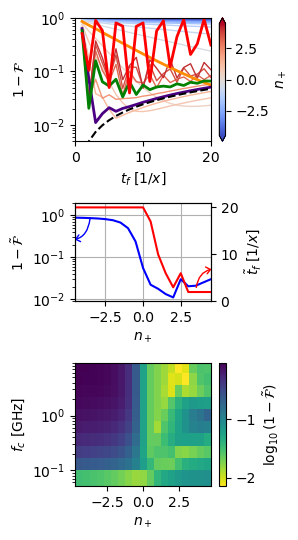

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(3., 5.5), gridspec_kw=dict(height_ratios=[1, 0.8, 1]))

# Gradient lines
ax, sm = plot_gradient_lines(tf_pulses, 1 - fidelities, alphas, betas, 
                             x_label=r'$t_f\; [1 / x]$', y_label=r'$1 - \mathcal{F}$',
                             ax=axs[0], legend_bool=False, cbar_bool=False)

plt.colorbar(sm, ax=axs[0], label=r'$n_+ $', location='right', extend='both')

axs[0].plot(tf_pulses, 1 / 2 * (1 - np.exp(-tf_pulses * gamma)), ls='--', c='k')
axs[0].set_yscale('log')
axs[0].set_ylim(5e-3, 1)
axs[0].set_xlim(0, 20)

# Best fidelities
cbar = plt.colorbar(sm, ax=axs[1], label=r'$n_+ $', location='right')
cbar.remove()

colors = ['b', 'r']
axs[1].plot(n_plus, 1 - F_tilde, c=colors[0])
axs[1].set_yscale('log')
axs[1].grid()

axs[1].set_xlim(np.min(n_plus[1:-1]), np.max(n_plus[1:-1]))
axs[1].set_ylim(None, 2)
axs[1].set_ylabel(r'$1 - \tilde{\mathcal{F}}$')
axs[1].set_xlabel(r'$n_+$')

ax2 = plt.twinx(axs[1])
ax2.plot(n_plus, tf_tilde, c=colors[1])
ax2.set_ylabel(r'$\tilde{t}_f \; [1 / x]$')
ax2.set_ylim(0, 21)

a1 = patches.FancyArrowPatch((-3.5, 19), (-5, 13), connectionstyle='angle3,angleA=90,angleB=0', shrinkA=5, shrinkB=5,
                             arrowstyle="->, head_width=2.5, head_length=3", color=colors[0])

a2 = patches.FancyArrowPatch((3.5, 1.5), (5, 7), connectionstyle='angle3,angleA=90,angleB=0', shrinkA=5, shrinkB=5,
                             arrowstyle="->, head_width=2.5, head_length=3", color=colors[1])
arrows = [a1, a2]

[ax2.add_patch(arrow) for arrow in arrows]

# Optimal lines
im = axs[2].pcolormesh(n_plus[1:-1], fc_list * optimal_GHZ_factor, np.log10(1 - optimal_max_fidelity[1:-1].T),
                       cmap='viridis_r', linewidth=0)

axs[2].set_xlabel(r'$n_+$')
axs[2].set_ylabel(r'$f_c$ [GHz]')
axs[2].set_yscale('log')

plt.colorbar(im, ax=axs[2], label=r'$\log_{10}(1 - \tilde{\mathcal{F}})$')

fig.tight_layout()